In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #plot the acf and pacf 

import statsmodels.api as sm  #LJung Box test
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
time=pd.read_csv("C:/Users/Singh/Downloads/ppi.csv",parse_dates=['yearqrt'],index_col='yearqrt')

<AxesSubplot:xlabel='yearqrt'>

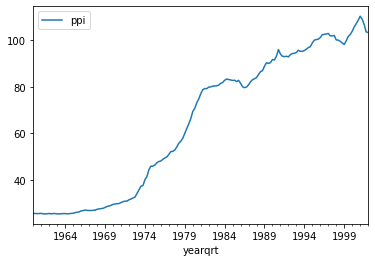

In [3]:
price=time[['ppi']]
price.plot()

Text(0.5, 1.0, 'Customer Price Index')

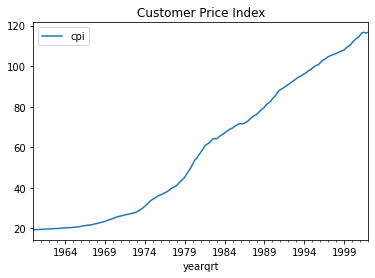

In [4]:
time[['cpi']].plot()
plt.title('Customer Price Index')

Text(0.5, 1.0, 'gross domestic produce')

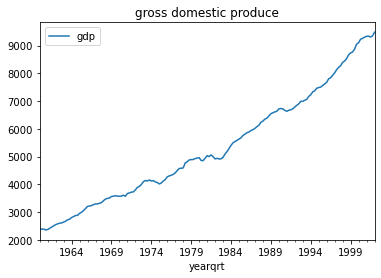

In [5]:
time[['gdp']].plot()
plt.title('gross domestic produce')

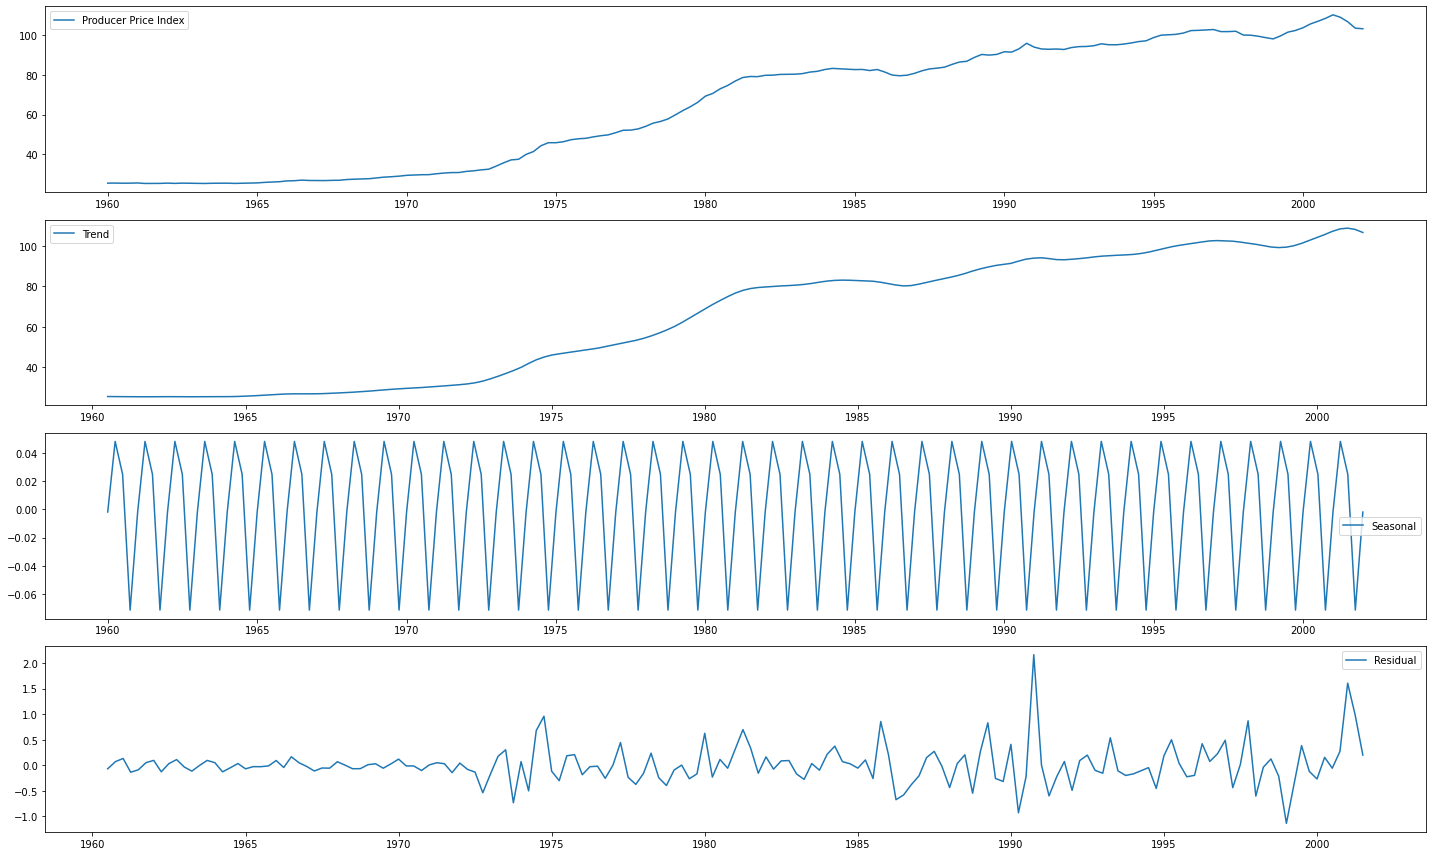

In [6]:
comp=seasonal_decompose(price,period=4)
price_trend=comp.trend
price_seasonal=comp.seasonal
price_residual=comp.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(price,label='Producer Price Index')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(price_trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(price_seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(price_residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

In [7]:
years=price[:20]


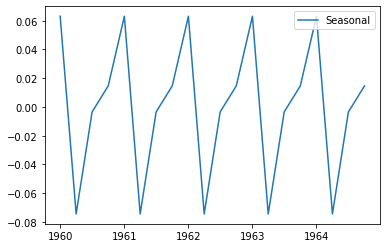

In [8]:
comp=seasonal_decompose(years,period=4)
years_seasonal=comp.seasonal
plt.plot(years_seasonal,label='Seasonal')
plt.legend(loc='best')

In [9]:
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [10]:
checkStationarity(price)

'p-value=0.8264804014424028. Data is not stationary'

In [11]:
from statsmodels.tsa.statespace.tools import diff
diff1 = price - price.shift()


In [12]:
diff1.dropna(inplace = True)
checkStationarity(diff1)

'p-value=0.0011801482847234588. Data is stationary'

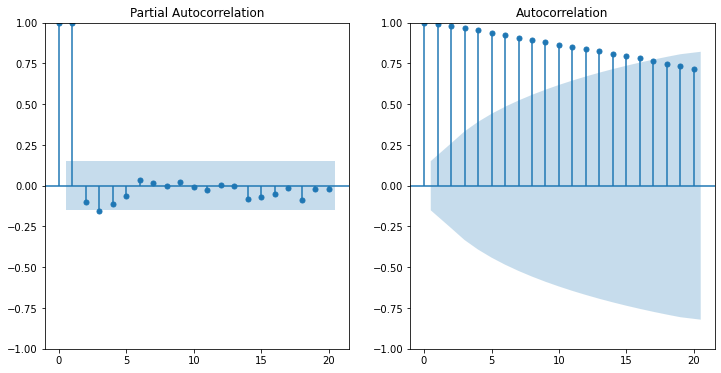

In [13]:
_,ax=plt.subplots(1,2,figsize=(12,6))

plot_pacf(price,lags=20,ax=ax[0]);
plot_acf(price,lags=20,ax=ax[1]);

In [14]:
#p=[0-2]
#q=[0-16]

In [15]:
ratio=0.7
ss1=int(len(price)*ratio)
train=price[:ss1]
test=price[ss1:]

In [16]:
p=[0,1,2] 
q=[0,1,2,3,4,5,6,7,8,9,10]

p1=[]
q1=[]
aic1=[]
rmse1=[]

def modelcheck(p,q):
    p1.append(p)
    q1.append(q)
    model=ARIMA(train,order=(p,1,q)).fit()
    aic=model.aic
    aic1.append(aic)
    fcast=model.forecast(len(test))
    rmse=mean_squared_error(test,fcast,squared=False)
    rmse1.append(rmse)

    
for i in p:
    for j in q:
        modelcheck(i,j)
        
df_value=pd.DataFrame({"p": p1,"q": q1,"aic":aic1,"RMSE":rmse1})
df_value.sort_values('RMSE').head()

,p,q,aic,RMSE
22,2,0,203.689024,3.988037
26,2,4,204.613732,4.007645
18,1,7,206.987052,4.051900
28,2,6,206.991311,4.112384
17,1,6,204.995452,4.163915


In [17]:
def arima(p,d,q,data,test1):
    arima.model=ARIMA(data,order=(p,d,q)).fit()
    arima.fc=arima.model.forecast(len(test1))
    arima.rmse_arima=mean_squared_error(test1,arima.fc,squared=False)
    arima.aic_arima=arima.model.aic
    print('RMSE for arima: ' + str(arima.rmse_arima))
    print('AIC for arima: ' + str(arima.aic_arima))
    test1.plot(figsize=(10,8),legend=True)
    arima.fc.plot(legend=True)
    plt.title("ACtual vs Predicted - Arima ")
    

RMSE for arima: 3.988037359122687
AIC for arima: 203.68902413628538


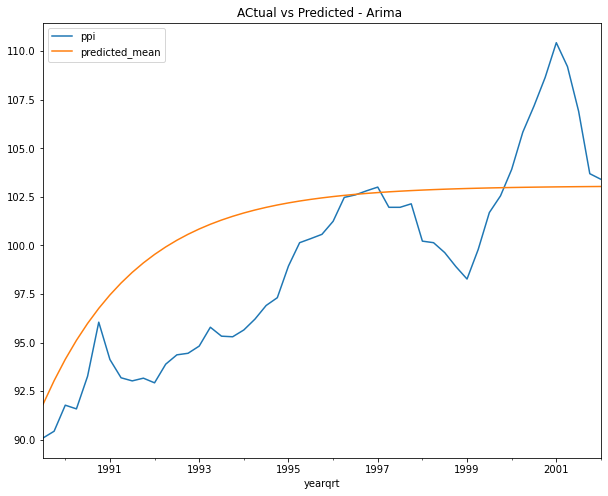

In [18]:
arima(2,1,0,train,test)

In [19]:
arima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ppi   No. Observations:                  118
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -98.845
Date:                Sun, 27 Nov 2022   AIC                            203.689
Time:                        11:52:52   BIC                            211.976
Sample:                    01-01-1960   HQIC                           207.053
                         - 04-01-1989                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5786      0.075      7.679      0.000       0.431       0.726
ar.L2          0.2778      0.060      4.648      0.000       0.161       0.395
sigma2         0.3140      0.031     10.040      0.000       0.253       0.375
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                12.40
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):              20.75   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
arimadf=pd.concat([test,arima.fc],axis=1)
arimadf['error']=arimadf.ppi-arimadf.predicted_mean

In [21]:
arimadf.head(10)

,ppi,predicted_mean,error
1989-07-01,90.089996,91.813780,-1.723784
1989-10-01,90.440002,93.039891,-2.599889
1990-01-01,91.779999,94.139253,-2.359254
1990-04-01,91.589996,95.115926,-3.525930
1990-07-01,93.269997,95.986404,-2.716407
1990-10-01,96.050003,96.761358,-0.711355
1991-01-01,94.129997,97.451544,-3.321547
1991-04-01,93.190002,98.066148,-4.876146
1991-07-01,93.029999,98.613474,-5.583475
1991-10-01,93.169998,99.100878,-5.930880
